In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [ ]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)

sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

sessions

In [271]:
basepath = r"Z:\Data\HMC1\day8"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"],putativeCellType="Pyr")
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.05)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [186]:
st = st[ep_epochs[2]]
ripple_epochs = ripple_epochs[ep_epochs[2]]

In [302]:
ca1_deep_idx = cell_metrics.brainRegion.str.contains("CA1").values & (cell_metrics.deepSuperficial== "Deep")
ca1_sup_idx = cell_metrics.brainRegion.str.contains("CA1").values & (cell_metrics.deepSuperficial== "Superficial")

ca1_deep_par = functions.get_participation(st.iloc[:,ca1_deep_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary",)
ca1_sup_par = functions.get_participation(st.iloc[:,ca1_sup_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")
# deep_sup_ratio = ca1_deep_par.sum(axis=0) / ca1_sup_par.sum(axis=0)
# deep_sup_ratio = ca1_deep_par.mean(axis=0) / ca1_sup_par.mean(axis=0)
deep_sup_ratio = (ca1_deep_par.sum(axis=0) - ca1_sup_par.sum(axis=0)) / (ca1_deep_par.sum(axis=0) + ca1_sup_par.sum(axis=0))



In [273]:
pfc_deep_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_sup_idx = cell_metrics.brainRegion.str.contains("MEC").values

pfc_par = functions.get_participation(st.iloc[:,pfc_deep_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")
mec_par = functions.get_participation(st.iloc[:,mec_sup_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")

<AxesSubplot:>

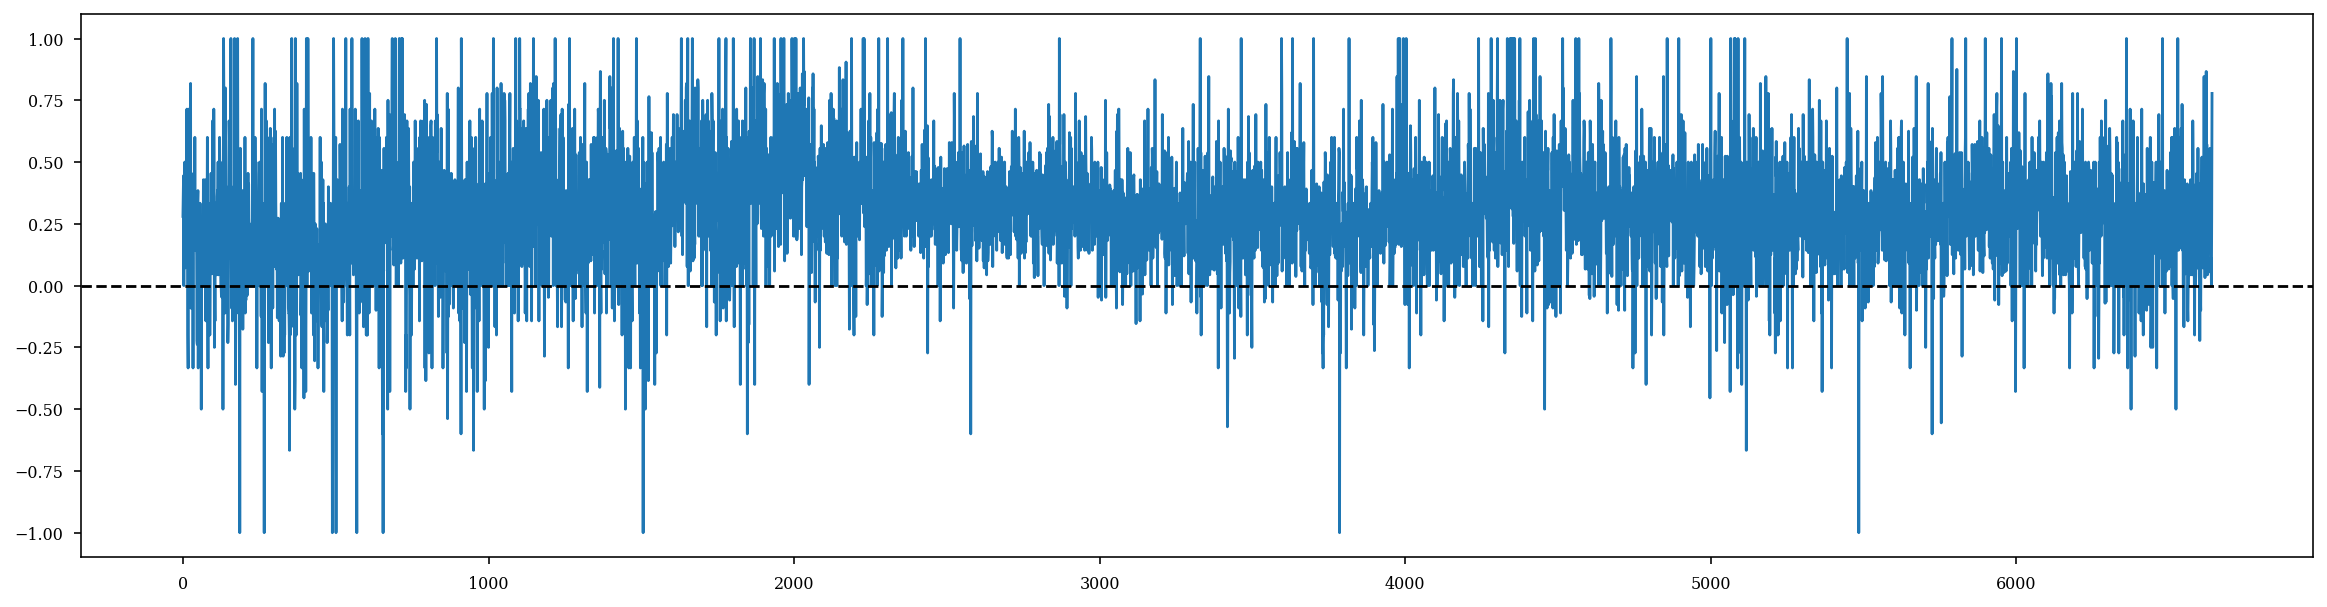

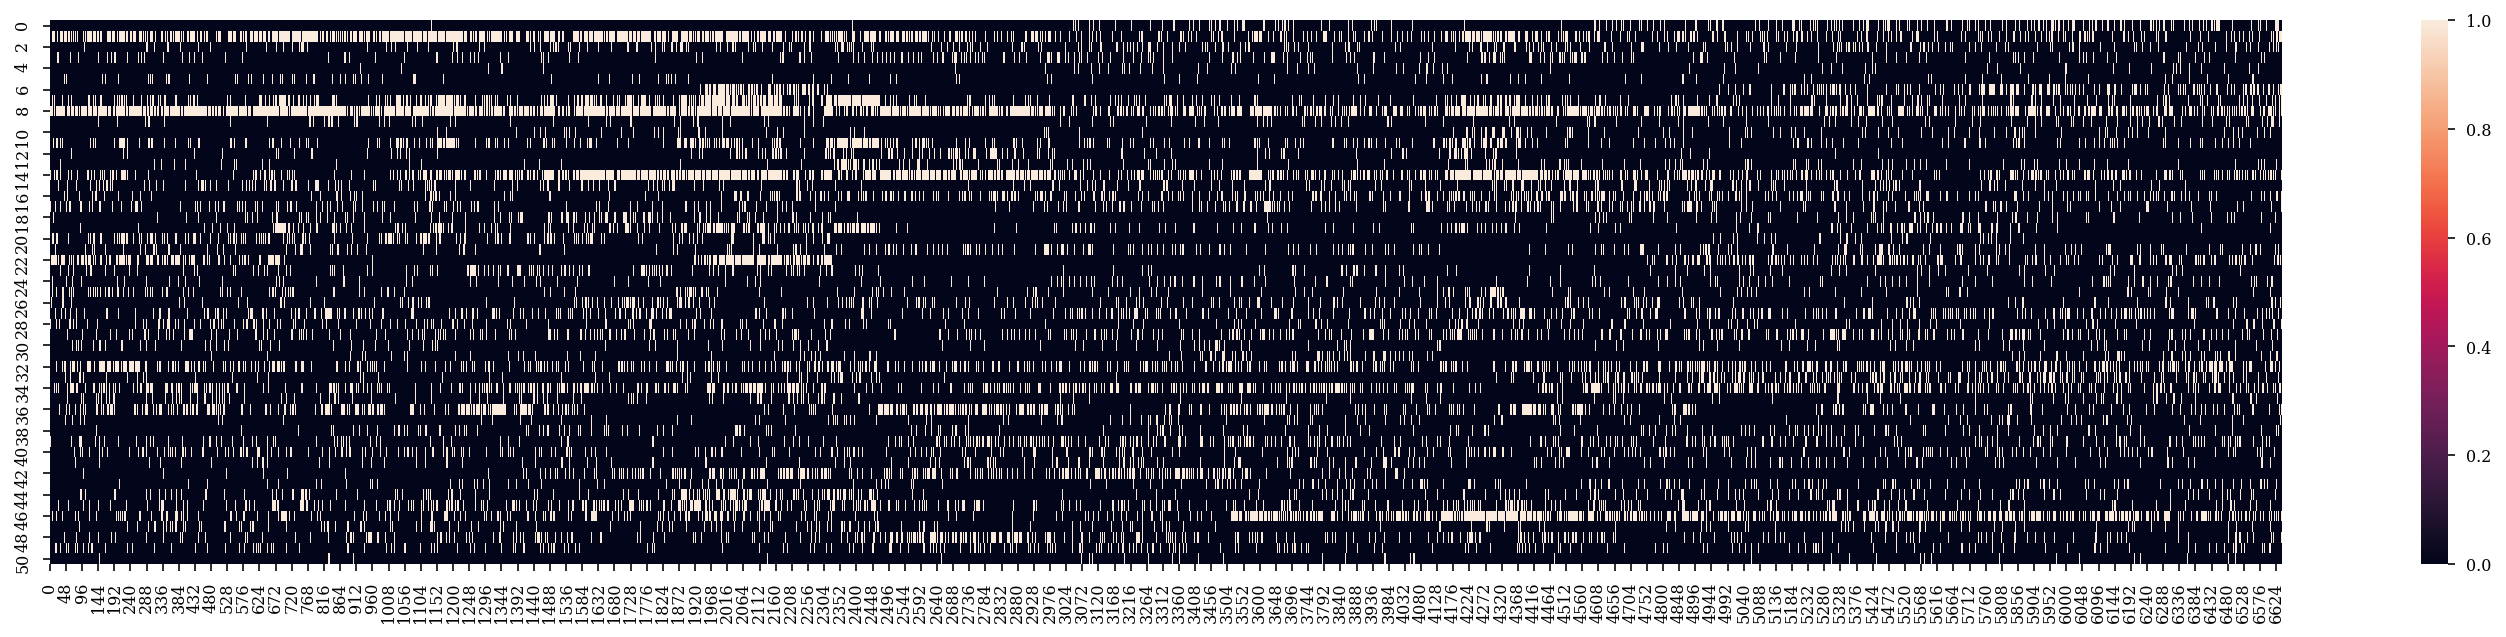

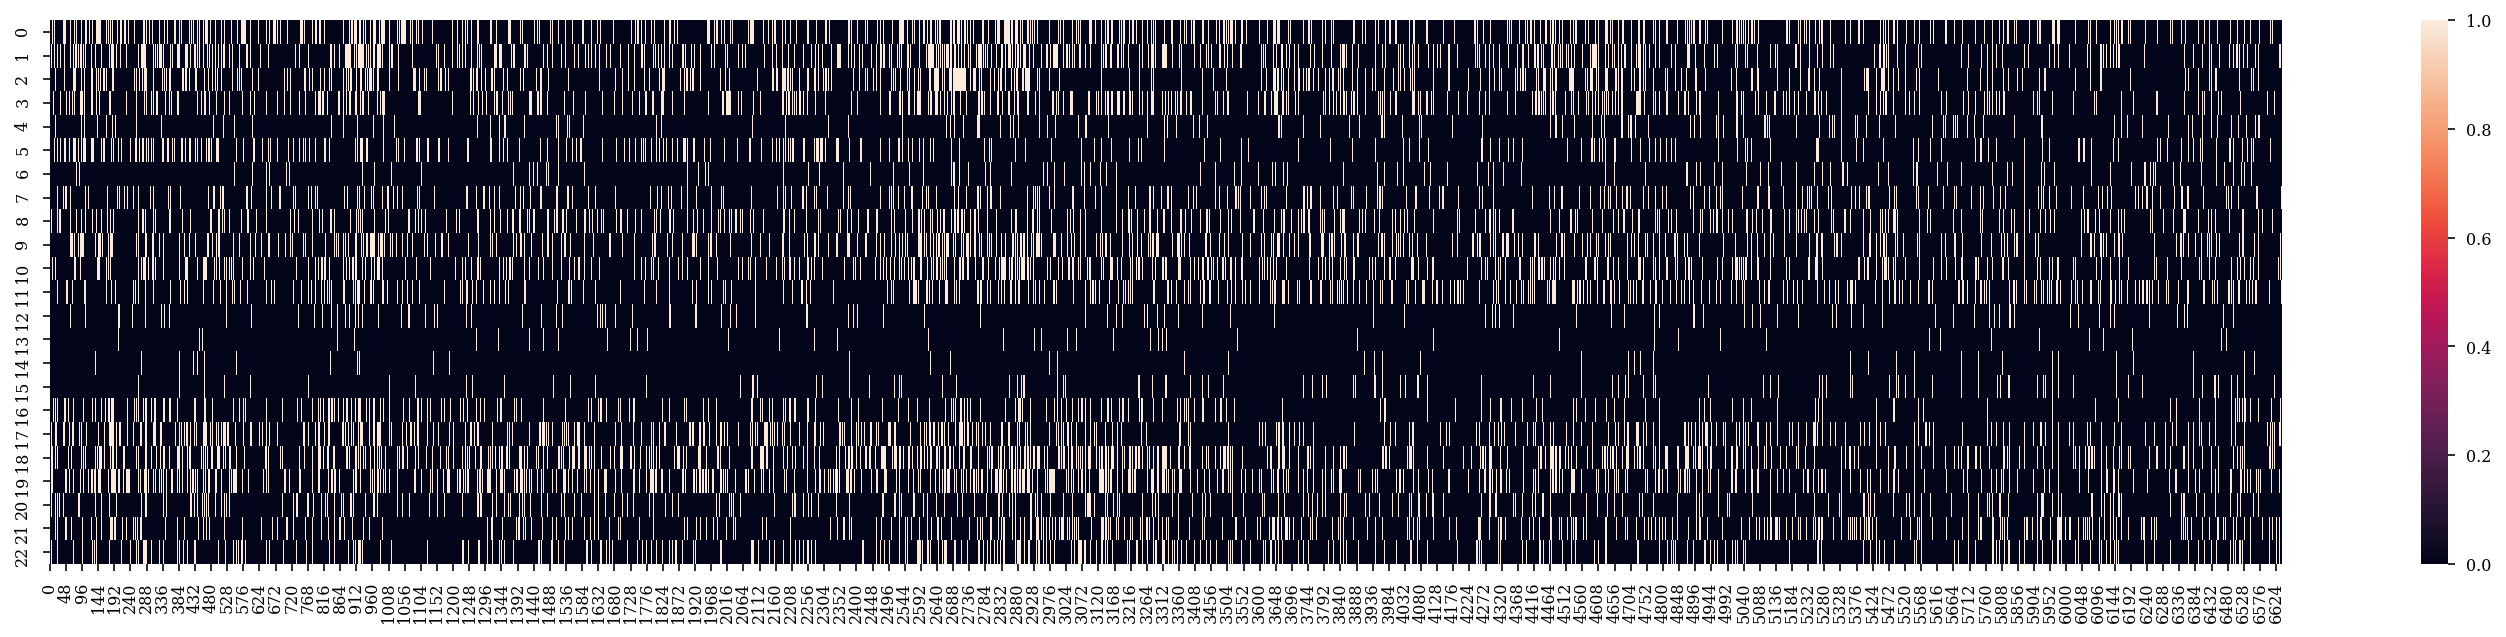

In [303]:
plt.figure(figsize=(20,5))
plt.plot(deep_sup_ratio)
plt.axhline(0,color="k",linestyle="--")
plt.figure(figsize=(25,5))
sns.heatmap(pfc_par)
plt.figure(figsize=(25,5))
sns.heatmap(mec_par)

In [304]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = mec_par.T
# y = np.log(deep_sup_ratio+1).reshape(-1,1)
y = deep_sup_ratio.reshape(-1,1)

bad_idx = np.isinf(deep_sup_ratio) | np.isnan(deep_sup_ratio)
y = y[~bad_idx]
X = X[~bad_idx]
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [305]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
pred = reg.predict(X_test)

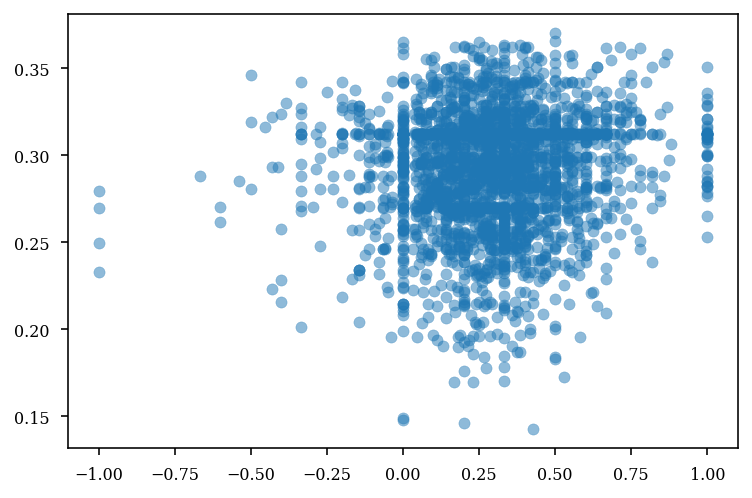

In [306]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
plt.show()

In [307]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

0.05526569059041814

In [308]:
reg = Ridge().fit(X_train, y_train)
reg.score(X_test, y_test)

0.0035886484862477364

In [309]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

model = xgb.XGBRegressor(seed = 123)
# define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = cross_val_score(model, X, y, cv=5)
# scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)

pred = model.predict(X_test)

Mean MAE: -0.238 (0.075)


In [310]:
score = model.score(X_test, y_test) 
score

-0.1727701755837805

In [311]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

0.06504709830648585

(0.0, 200.0)

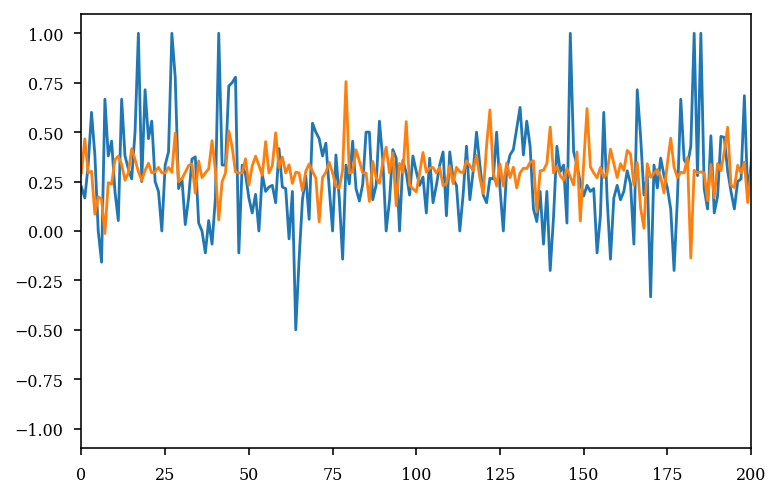

In [312]:
plt.plot(y_test)
plt.plot(pred)
plt.xlim(0,200)

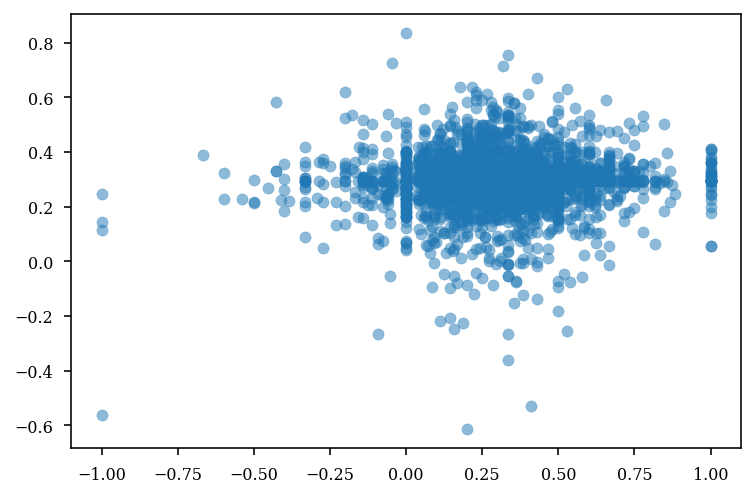

In [314]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [295]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
 
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.287747


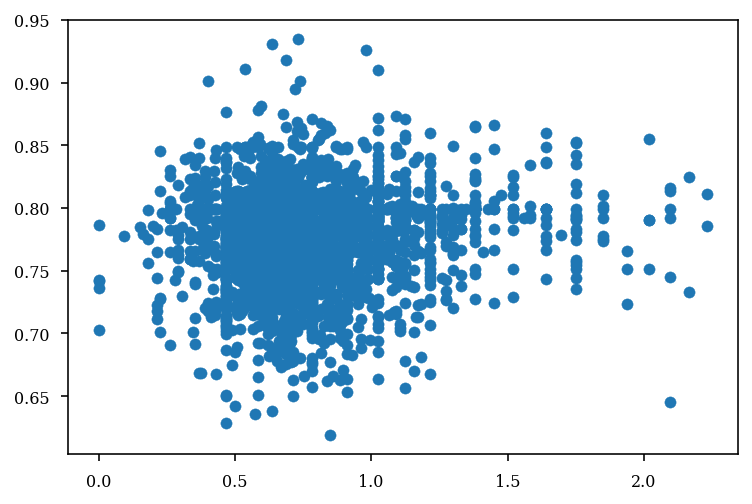

In [297]:
plt.scatter(y_test,pred)
# plt.axis("square")

In [298]:
reg = Lasso().fit(X_train, y_train)
reg.score(X_test, y_test)

-6.0279201143709216e-05

In [299]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
reg = BaggingRegressor(extra_tree, random_state=0).fit(
    X_train, y_train)
reg.score(X_test, y_test)

-0.20827310041102876

In [300]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2614, 23), (2614, 1), (3920, 23), (3920, 1))

In [301]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

reg = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(extra_tree, random_state=0))

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.25122904 -0.19895562 -0.41078681 -0.20635456 -0.16995342]
-0.25 accuracy with a standard deviation of 0.09
